# IMPORT DATASET

In [1]:
"""# Install kaggle dan kagglehub jika belum
!pip install -q kagglehub

import kagglehub

# Download dataset dari Kaggle (otomatis simpan ke cache)
path = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")
print("Path to dataset files:", path)"""

'# Install kaggle dan kagglehub jika belum\n!pip install -q kagglehub\n\nimport kagglehub\n\n# Download dataset dari Kaggle (otomatis simpan ke cache)\npath = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")\nprint("Path to dataset files:", path)'

In [2]:
import os
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dense,
                                     Dropout, Input, BatchNormalization)
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import ResNet50, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, classification_report

# Mengabaikan peringatan
import warnings
warnings.simplefilter('ignore')

2025-06-12 16:34:29.436137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749746069.638672      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749746069.696732      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DATA LOAD

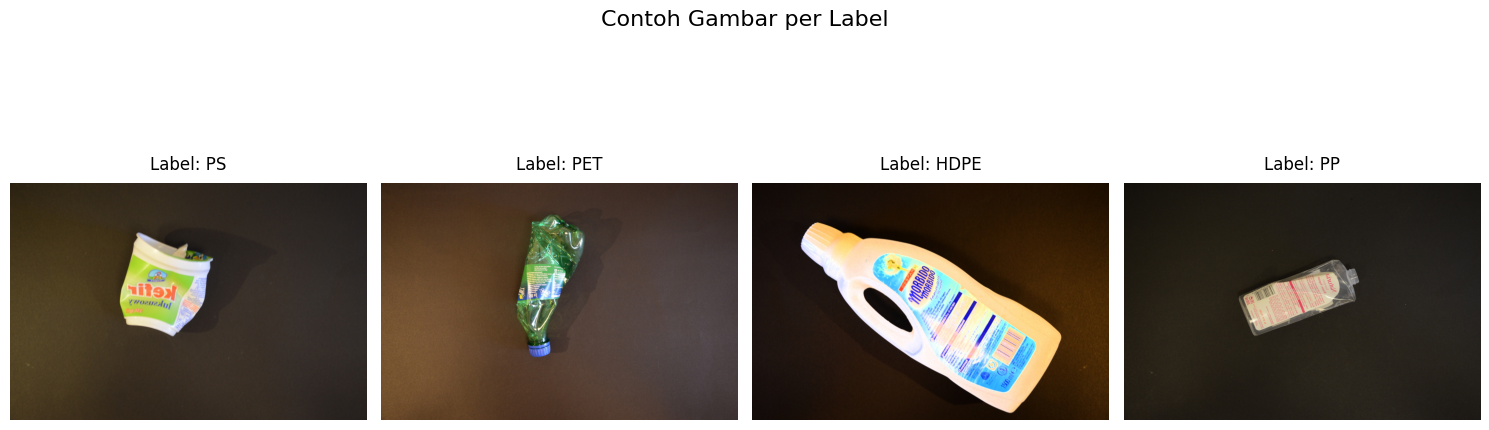

In [3]:
# Path dataset
df = "/kaggle/input/waste-images"

# mengelompokkan berdasarkan label
label_to_images = {}  # Kamus: {label: [list_path_gambar]}

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = os.path.basename(root)  
            if label not in label_to_images:
                label_to_images[label] = []
            label_to_images[label].append(os.path.join(root, file))

# Menampilkan 1 gambar acak per label 
labels = list(label_to_images.keys())
if len(labels) > 4:
    labels = random.sample(labels, 4)  # Ambil 4 label acak jika label > 4

selected_images = []
for label in labels:
    images = label_to_images[label]
    selected_images.append((label, random.choice(images)))  # (label, path_gambar)

plt.figure(figsize=(15, 5))
plt.suptitle("Contoh Gambar per Label", fontsize=16, y=1.05)  # Judul utama

for i, (label, img_path) in enumerate(selected_images):
    img = Image.open(img_path)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}", pad=10)  # `pad` memberi jarak antara judul dan gambar
    plt.axis('off')

plt.tight_layout()
plt.show()

# DATA UNDERSTANDING

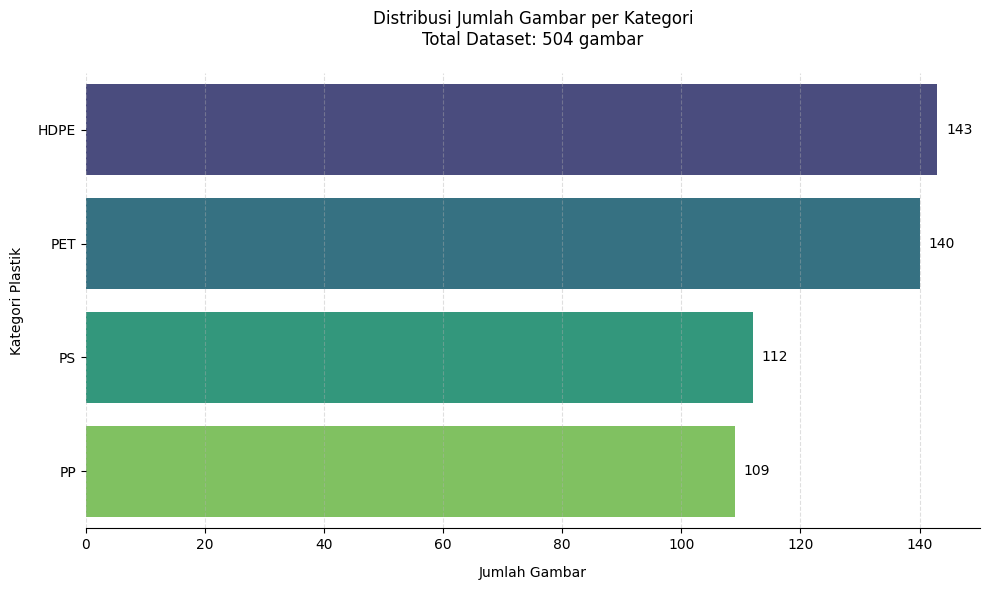

In [4]:
# Menghitung jumlah gambar per kategori
category_counts = {}
total_images = 0  
image_paths = []

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.basename(root)  
            category_counts[label] = category_counts.get(label, 0) + 1
            total_images += 1
            image_paths.append(os.path.join(root, file))

# Konversi ke DataFrame
df_counts = pd.DataFrame(list(category_counts.items()), columns=["Label", "Jumlah Gambar"])
df_counts = df_counts.sort_values("Jumlah Gambar", ascending=False)  

# Visualisasi bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_counts,
    y="Label",  
    x="Jumlah Gambar",  
    palette="viridis",  
    orient="h"  
)

# Tambahkan nilai di ujung bar
for i, value in enumerate(df_counts["Jumlah Gambar"]):
    barplot.text(
        value + max(df_counts["Jumlah Gambar"])*0.01,  
        i,  # Posisi Y
        f"{value:,}", 
        ha='left',  
        va='center',  
        fontsize=10
    )

plt.title(f"Distribusi Jumlah Gambar per Kategori\nTotal Dataset: {total_images} gambar", pad=20)
plt.xlabel("Jumlah Gambar", labelpad=10)
plt.ylabel("Kategori Plastik", labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)  
sns.despine(left=True)  
plt.tight_layout()
plt.show()

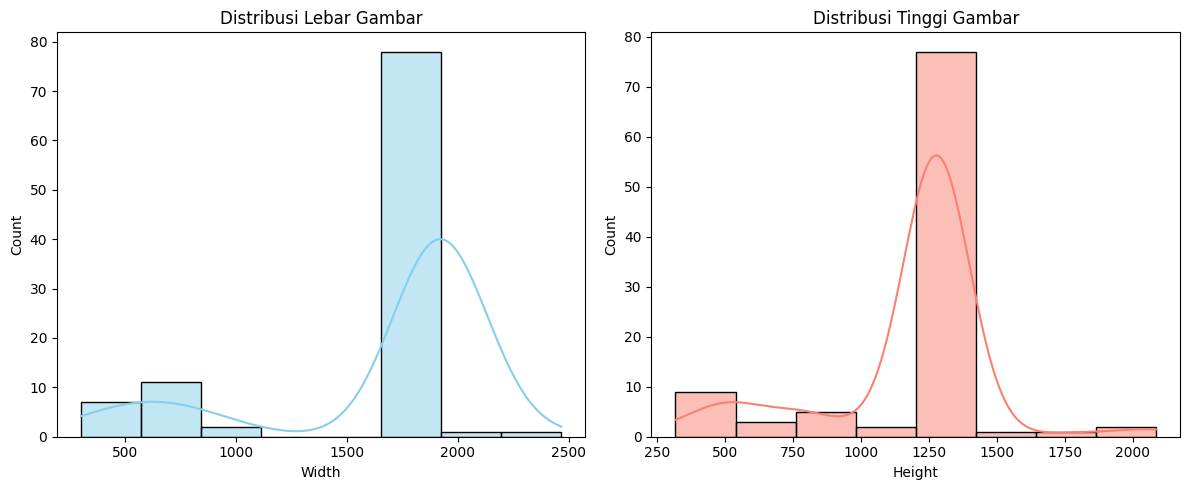

In [5]:
# Menampilkan distribusi ukuran gambar
image_sizes = []
sample_images = random.sample(image_paths, min(100, len(image_paths)))  # contoh 100 gambar

for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except:
        continue

# Konversi ke DataFrame
df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Visualisasi distribusi ukuran
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_sizes['Width'], kde=True, color='skyblue')
plt.title("Distribusi Lebar Gambar")

plt.subplot(1, 2, 2)
sns.histplot(df_sizes['Height'], kde=True, color='salmon')
plt.title("Distribusi Tinggi Gambar")

plt.tight_layout()
plt.show()

# DATA SPLITTING

In [6]:
# Direktori training dan testing (80/20)
TRAIN_DIR = "/kaggle/input/waste-images/train"
TEST_DIR = "/kaggle/input/waste-images/val"

train_HDPE = os.path.join(TRAIN_DIR + '/HDPE')
train_PET = os.path.join(TRAIN_DIR + '/PET')
train_PP = os.path.join(TRAIN_DIR + '/PP')
train_PS = os.path.join(TRAIN_DIR + '/PS')
test_HDPE = os.path.join(TEST_DIR + '/HDPE')
test_PET = os.path.join(TEST_DIR + '/PET')
test_PP = os.path.join(TEST_DIR + '/PP')
test_PS = os.path.join(TEST_DIR + '/PS')

print("TRAIN\n")
print("Total number of HDPE images in training set: ",len(os.listdir(train_HDPE)))
print("Total number of PET images in training set: ",len(os.listdir(train_PET)))
print("Total number of PP images in training set: ",len(os.listdir(train_PP)))
print("Total number of PS images in training set: ",len(os.listdir(train_PS)))
print("\nTEST\n")
print("Total number of HDPE images in test set: ",len(os.listdir(test_HDPE)))
print("Total number of PET images in test set: ",len(os.listdir(test_PET)))
print("Total number of PP images in test set: ",len(os.listdir(test_PP)))
print("Total number of PS images in test set: ",len(os.listdir(test_PS)))

TRAIN

Total number of HDPE images in training set:  114
Total number of PET images in training set:  112
Total number of PP images in training set:  87
Total number of PS images in training set:  89

TEST

Total number of HDPE images in test set:  29
Total number of PET images in test set:  28
Total number of PP images in test set:  22
Total number of PS images in test set:  23


In [7]:
# Mempersiapkan data gambar untuk pelatihan
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   
)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 324 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 102 images belonging to 4 classes.


# MODELLING

## CNN

In [8]:
# CNN 
model_1 = Sequential()

# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Input(shape=(150,150,3)))  # Ini layer pertama
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.3))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.2))

# multiclass (softmax)
model_1.add(Dense(4, activation='softmax'))

# Compile model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

I0000 00:00:1749746086.231912      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,411,204 (20.64 MB)

 Trainable params: 5,410,756 (20.64 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [9]:
RESULT_PATH = ''  # Ganti dengan path hasil pelatihan
OUTPUT_DIR = '/kaggle/working/outputs'

if os.path.exists(f"{RESULT_PATH}/training_outputs"):
    print("Memuat file hasil training sebelumnya...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Copy dari dataset ke working directory
    shutil.copytree(f"{RESULT_PATH}/training_outputs", OUTPUT_DIR, dirs_exist_ok=True)
    
    # Pindahkan file ke root working directory
    for file in ['final_model_1.h5', 'training_history_1.csv', 'training_log_1.csv']:
        if os.path.exists(f"{OUTPUT_DIR}/{file}"):
            shutil.copy(f"{OUTPUT_DIR}/{file}", '/kaggle/working/')


model_path = 'final_model_1.h5'
history_path = 'training_history_1.csv'
log_path = 'training_log_1.csv'
retrain = False # Ganti menjadi true jika ingin training ulang

if os.path.exists(model_path) and os.path.exists(history_path) and not retrain:
    print("Model sudah dilatih sebelumnya. Memuat hasil yang tersimpan...")
    
    # Muat model
    model_1 = load_model(model_path)
    
    # Muat history dan tampilkan
    history_df = pd.read_csv(history_path)
    print("\n=== Riwayat Pelatihan ===")
    print(history_df.tail())  # Tampilkan 5 epoch terakhir
    
    # Tampilkan log epoch dari CSVLogger 
    if os.path.exists(log_path):
        epoch_logs = pd.read_csv(log_path)
        print("\n=== Log Epoch Lengkap ===")
        print(epoch_logs)

else:
    print("Model belum dilatih. Memulai pelatihan...")
    
    # Hapus file lama jika ada
    for f in [model_path, history_path, log_path, 'best_model_1.h5']:
        if os.path.exists(f):
            os.remove(f)
    
    # Simpan log training ke CSV
    csv_logger = CSVLogger(log_path)
    
    # Simpan model terbaik selama training
    checkpoint = ModelCheckpoint(
        'best_model_1.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  
        min_delta=0.0001,
        mode='auto',
        restore_best_weights=True
    )

    %time
    
    # Fitting / training model
    history_1 = model_1.fit(train_generator,
                            epochs=100,
                            batch_size=32,
                            validation_data=validation_generator,
                            callbacks=[csv_logger, checkpoint, early_stopping]
    )
    
    # Simpan model akhir
    model_1.save(model_path)
    
    # Simpan history ke DataFrame
    history_df = pd.DataFrame(history_1.history)
    history_df.to_csv(history_path, index=False)

    print("Menyimpan hasil training...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    for file in [model_path, history_path, log_path, 'best_model_1.h5']:
        if os.path.exists(file):
            shutil.copy(file, OUTPUT_DIR)
    
    shutil.make_archive('training_outputs', 'zip', OUTPUT_DIR)
    print("File hasil training siap di-download!")

Model belum dilatih. Memulai pelatihan...
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
Epoch 1/100


I0000 00:00:1749746093.839373      83 service.cc:148] XLA service 0x7c99180145b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749746093.840201      83 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749746094.345068      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:38 10s/step - accuracy: 0.2500 - loss: 2.3630

I0000 00:00:1749746098.911165      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2670 - loss: 8.6054 - val_accuracy: 0.2564 - val_loss: 28.6557
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 613ms/step - accuracy: 0.4145 - loss: 5.4614 - val_accuracy: 0.1667 - val_loss: 14.9878
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - accuracy: 0.4193 - loss: 4.9438 - val_accuracy: 0.2308 - val_loss: 16.5089
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 570ms/step - accuracy: 0.4411 - loss: 2.5869 - val_accuracy: 0.3077 - val_loss: 7.6056
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 560ms/step - accuracy: 0.4302 - loss: 2.2232 - val_accuracy: 0.3077 - val_loss: 5.7238
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 559ms/step - accuracy: 0.4304 - loss: 2.6882 - val_accuracy: 0.2051 - val_loss: 3.6872
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - accuracy: 0.4616 - loss: 2.1851 - val_accuracy: 0.2692 - val_loss: 2.2537
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - accuracy: 0.4782 - loss: 1.5291 - val_accuracy: 0.192

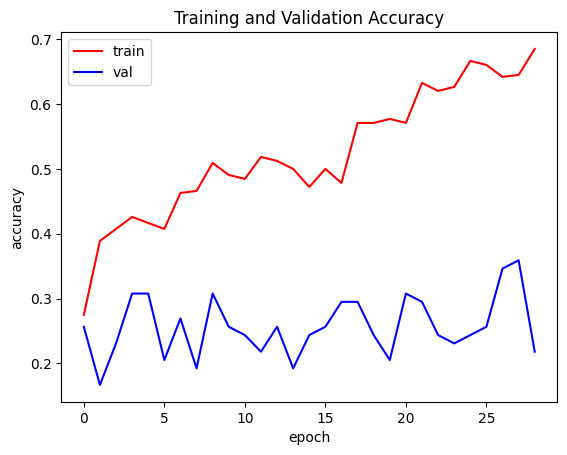

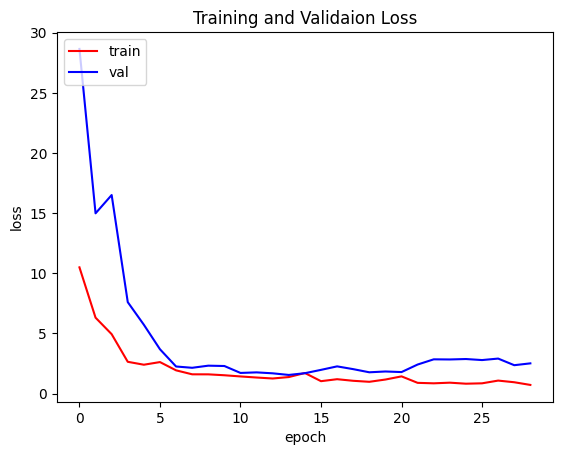

In [10]:
# Menampilkan grafik hasil akurasi dan loss 

acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validaion Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

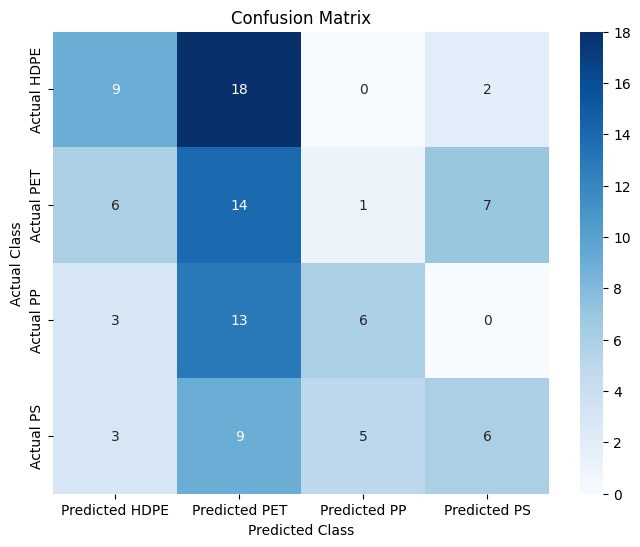


Classification Report:
              precision    recall  f1-score   support

        HDPE     0.4286    0.3103    0.3600        29
         PET     0.2593    0.5000    0.3415        28
          PP     0.5000    0.2727    0.3529        22
          PS     0.4000    0.2609    0.3158        23

    accuracy                         0.3431       102
   macro avg     0.3970    0.3360    0.3425       102
weighted avg     0.3911    0.3431    0.3434       102



In [11]:
# Menampilkan confusion matrix

test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
pred_labels = np.argmax(preds_1, axis=1)  # Ambil kelas prediksi

# Ground truth
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # ['HDPE', 'PET', 'PP', 'PS']

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f'Actual {c}' for c in class_names],
                        columns=[f'Predicted {c}' for c in class_names])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

## Resnet

In [12]:
# Mempersiapkan data gambar untuk pelatihan
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   
)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 324 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 102 images belonging to 4 classes.


In [13]:
# Load model ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze strategi berdasarkan block (fine tuning)
for layer in base_model.layers:  
    layer.trainable = False

# Unfreeze block terakhir
for layer in base_model.layers:  
    if 'conv5_block' in layer.name: 
        layer.trainable = True

# Menambahkan top model 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)  # Tambah unit
x = Dropout(0.5)(x)  # Dropout lebih agresif
x = Dense(256, activation='relu')(x)  # Layer tambahan
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x) 

model_2 = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
RESULT_PATH = ''  # Ganti dengan path hasil pelatihan
OUTPUT_DIR = '/kaggle/working/outputs'

if os.path.exists(f"{RESULT_PATH}/training_outputs"):
    print("Memuat file hasil training sebelumnya...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Copy dari dataset ke working directory
    shutil.copytree(f"{RESULT_PATH}/training_outputs", OUTPUT_DIR, dirs_exist_ok=True)
    
    # Pindahkan file ke root working directory
    for file in ['final_model_2.h5', 'training_history_2.csv', 'training_log_2.csv']:
        if os.path.exists(f"{OUTPUT_DIR}/{file}"):
            shutil.copy(f"{OUTPUT_DIR}/{file}", '/kaggle/working/')


model_path = 'final_model_2.h5'
history_path = 'training_history_2.csv'
log_path = 'training_log_2.csv'
retrain = False # Ganti menjadi true jika ingin training ulang

if os.path.exists(model_path) and os.path.exists(history_path) and not retrain:
    print("Model sudah dilatih sebelumnya. Memuat hasil yang tersimpan...")
    
    # Muat model
    model_2 = load_model(model_path)
    
    # Muat history dan tampilkan
    history_df = pd.read_csv(history_path)
    print("\n=== Riwayat Pelatihan ===")
    print(history_df.tail())  # Tampilkan 5 epoch terakhir
    
    # Tampilkan log epoch dari CSVLogger
    if os.path.exists(log_path):
        epoch_logs = pd.read_csv(log_path)
        print("\n=== Log Epoch Lengkap ===")
        print(epoch_logs)

else:
    print("Model belum dilatih. Memulai pelatihan...")
    
    # Hapus file lama jika ada
    for f in [model_path, history_path, log_path, 'best_model_2.h5']:
        if os.path.exists(f):
            os.remove(f)
    
    # Simpan log training ke CSV
    csv_logger = CSVLogger(log_path)
    
    # Simpan model terbaik selama training
    checkpoint = ModelCheckpoint(
        'best_model_2.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  
        min_delta=0.0001,
        mode='auto',
        restore_best_weights=True
    )
    
    class_indices = train_generator.classes
    class_weights = compute_class_weight('balanced', 
                                        classes=np.unique(class_indices), 
                                        y=class_indices)
    class_weights_dict = dict(enumerate(class_weights))

    %time
    
    # Menambahkan callback
    reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
    )
    
    # Fitting / training model
    history_2 = model_2.fit(train_generator,
                            epochs=100,
                            validation_data=validation_generator,
                            class_weight = class_weights_dict,
                            callbacks=[csv_logger, checkpoint, early_stopping, reduce_lr]
    )
    
    # Simpan model akhir
    model_2.save(model_path)
    
    # Simpan history ke DataFrame
    history_df = pd.DataFrame(history_2.history)
    history_df.to_csv(history_path, index=False)

    print("Menyimpan hasil training...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    for file in [model_path, history_path, log_path, 'best_model_2.h5']:
        if os.path.exists(file):
            shutil.copy(file, OUTPUT_DIR)
    
    shutil.make_archive('training_outputs', 'zip', OUTPUT_DIR)
    print("File hasil training siap di-download!")

Model belum dilatih. Memulai pelatihan...
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2627 - loss: 1.9765 - val_accuracy: 0.4103 - val_loss: 1.2333 - learning_rate: 1.0000e-04
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.6463 - loss: 0.8673 - val_accuracy: 0.4615 - val_loss: 1.2162 - learning_rate: 1.0000e-04
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - accuracy: 0.7692 - loss: 0.6214 - val_accuracy: 0.4744 - val_loss: 1.2419 - learning_rate: 1.0000e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.8505 - loss: 0.4538 - val_accuracy: 0.4872 - val_loss: 1.1426 - learning_rate: 1.0000e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 676ms/step - accuracy: 0.9094 - loss: 0.2815 - val_accuracy: 0.5641 - val_loss: 1.0746 - learning_rate: 1.0000e-04
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 653ms/step - accuracy: 0.9362 - loss: 0.1983 - val_accuracy: 0.61

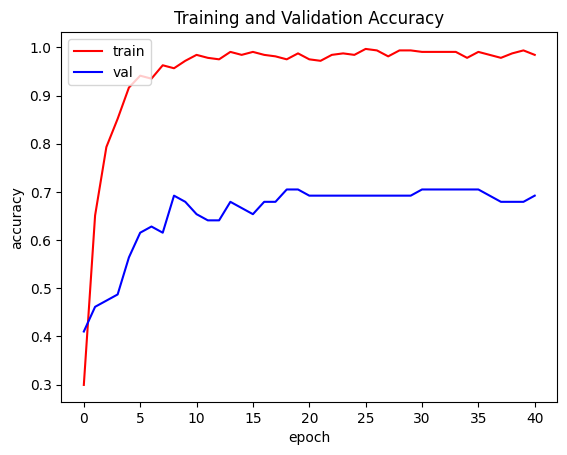

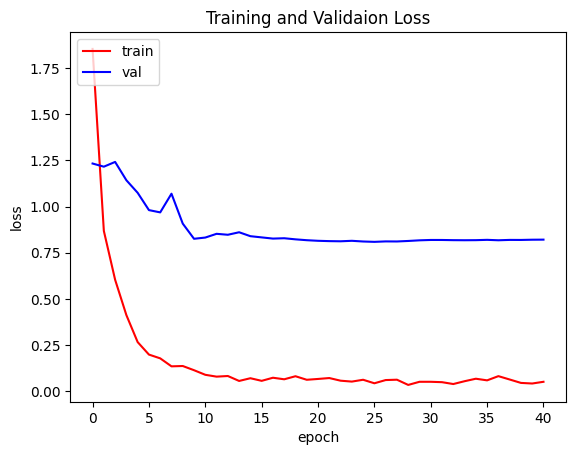

In [15]:
# Menampilkan grafik hasil akurasi dan loss 

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validaion Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

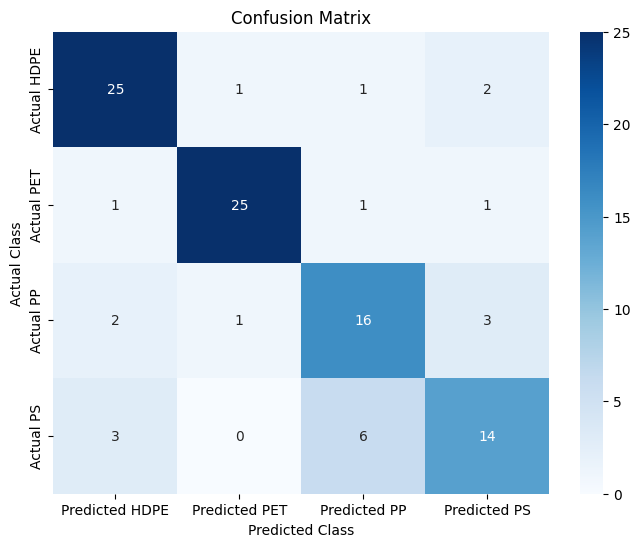


Classification Report:
              precision    recall  f1-score   support

        HDPE     0.8065    0.8621    0.8333        29
         PET     0.9259    0.8929    0.9091        28
          PP     0.6667    0.7273    0.6957        22
          PS     0.7000    0.6087    0.6512        23

    accuracy                         0.7843       102
   macro avg     0.7748    0.7727    0.7723       102
weighted avg     0.7851    0.7843    0.7834       102



In [16]:
# Menampilkan confusion matrix

test_generator.reset()

preds_2 = model_2.predict(test_generator,verbose=0)
pred_labels = np.argmax(preds_2, axis=1)  # Ambil kelas prediksi

# Ground truth
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # ['HDPE', 'PET', 'PP', 'PS']

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f'Actual {c}' for c in class_names],
                        columns=[f'Predicted {c}' for c in class_names])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

## EfficientNet

In [17]:
# Mempersiapkan data gambar untuk pelatihan
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   
)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(512,512),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(512,512),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(512,512),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 324 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 102 images belonging to 4 classes.


In [18]:
# Load model EfficientNetB7
base_model = EfficientNetB7(
    weights='imagenet', 
    include_top=False, 
    input_shape=(512,512,3)  
)

# Menambahkan top model 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)  # Dropout 
x = Dense(256, activation='relu')(x)  # Layer tambahan
x = Dropout(0.3)(x) 
predictions = Dense(4, activation='softmax')(x) 

model_3 = Model(inputs=base_model.input, outputs=predictions)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [19]:
RESULT_PATH = ''  # Ganti dengan path hasil pelatihan
OUTPUT_DIR = '/kaggle/working/outputs'

if os.path.exists(f"{RESULT_PATH}/training_outputs"):
    print("Memuat file hasil training sebelumnya...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Copy dari dataset ke working directory
    shutil.copytree(f"{RESULT_PATH}/training_outputs", OUTPUT_DIR, dirs_exist_ok=True)
    
    # Pindahkan file ke root working directory
    for file in ['final_model_3.h5', 'best_model_3.h5', 'training_history_3.csv', 'training_log_3.csv']:
        if os.path.exists(f"{OUTPUT_DIR}/{file}"):
            shutil.copy(f"{OUTPUT_DIR}/{file}", '/kaggle/working/')


model_path = 'final_model_3.h5'
best_model_path = 'best_model_3.h5'
history_path = 'training_history_3.csv'
log_path = 'training_log_3.csv'
retrain = False # Ganti menjadi true jika ingin training ulang

if os.path.exists(model_path) and not retrain:
    print("Model sudah dilatih sebelumnya. Memuat hasil yang tersimpan...")
    
    # Muat model
    model_3 = load_model(model_path)
    
    # Muat history dan tampilkan
    history_df = pd.read_csv(history_path)
    print("\n=== Riwayat Pelatihan ===")
    print(history_df.tail())  
    
    # Tampilkan log epoch dari CSVLogger 
    if os.path.exists(log_path):
        epoch_logs = pd.read_csv(log_path)
        print("\n=== Log Epoch Lengkap ===")
        print(epoch_logs)

else:
    print("Model belum dilatih. Memulai pelatihan...")
    
    # Hapus file lama jika ada
    for f in [model_path, history_path, log_path, best_model_path]:
        if os.path.exists(f):
            os.remove(f)
    
    # Simpan log training ke CSV
    csv_logger = CSVLogger(log_path)
    
    # Simpan model terbaik selama training
    checkpoint = ModelCheckpoint(
        best_model_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  
        min_delta=0.0001,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    mode='min',
    verbose=1
    )
    
    class_indices = train_generator.classes
    class_weights = compute_class_weight('balanced', 
                                        classes=np.unique(class_indices), 
                                        y=class_indices)
    class_weights_dict = dict(enumerate(class_weights))
        
    base_model.trainable = False

    # Melatih Head model
    initial_lr = 1e-3 
    model_3.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Melatih head epoch
    epochs_head = 15
    history_head = model_3.fit(
        train_generator,
        epochs=epochs_head, # Latih head selama 10 epoch dulu
        validation_data=validation_generator,
        class_weight=class_weights_dict,
        callbacks=[csv_logger, checkpoint, early_stopping, reduce_lr] # Tanpa unfreeze callback
    )

    # Unfreeze (fine-tuning)
    base_model.trainable = True
    
    freeze_first_n = 400
    for layer in base_model.layers[:freeze_first_n]:
        layer.trainable = False
    
    finetune_lr = 1e-5
    model_3.compile(
        optimizer=Adam(learning_rate=finetune_lr), # LR rendah!
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Melanjutkan pelatihan untuk sisa epoch
    total_epochs = 100
    initial_epoch_finetune = history_head.epoch[-1] + 1
    
    history_finetune = model_3.fit(
        train_generator,
        epochs=total_epochs, 
        initial_epoch=initial_epoch_finetune, 
        validation_data=validation_generator,
        class_weight=class_weights_dict,
        callbacks=[csv_logger, checkpoint, early_stopping, reduce_lr] 
    )
    print(f"Memuat bobot terbaik dari {best_model_path} sebelum menyimpan model final.")
    model_3.load_weights(best_model_path)
    
    # Simpan model akhir
    model_3.save(model_path)
    
    # Simpan history ke DataFrame
    history_head_df = pd.DataFrame(history_head.history)
    history_finetune_df = pd.DataFrame(history_finetune.history)
    full_history_df = pd.concat([history_head_df, history_finetune_df], ignore_index=True)
    full_history_df.to_csv(history_path, index=False)

    print(f"Model akhir disimpan di: {model_path}")
    print(f"History lengkap disimpan di: {history_path}")
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    for file in [model_path, best_model_path, history_path, log_path]:
        if os.path.exists(file):
            shutil.copy(file, OUTPUT_DIR)
    
    shutil.make_archive('training_outputs', 'zip', OUTPUT_DIR)
    print("File hasil training siap di-download!")

Model belum dilatih. Memulai pelatihan...
Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5207 - loss: 1.3473
Epoch 1: val_loss improved from inf to 0.83433, saving model to best_model_3.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.5311 - loss: 1.3258 - val_accuracy: 0.7308 - val_loss: 0.8343 - learning_rate: 0.0010
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8740 - loss: 0.3429
Epoch 2: val_loss improved from 0.83433 to 0.66308, saving model to best_model_3.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8750 - loss: 0.3422 - val_accuracy: 0.7692 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9219 - loss: 0.2421
Epoch 3: val_loss improved from 0.66308 to 0.65876, saving model to best_model_3.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9228 - loss: 0.2417 - val_accuracy: 0.7436 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━

E0000 00:00:1749747177.792160      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747178.053904      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747179.410639      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747179.720368      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747180.802152      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 8/11 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7516 - loss: 1.5012

E0000 00:00:1749747274.018053      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747274.259051      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747274.872992      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747275.151020      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749747275.766412      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7444 - loss: 1.5035
Epoch 16: val_loss did not improve from 0.36646
11/11 ━━━━━━━━━━━━━━━━━━━━ 336s 12s/step - accuracy: 0.7425 - loss: 1.4999 - val_accuracy: 0.8462 - val_loss: 0.3756 - learning_rate: 1.0000e-05
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7798 - loss: 1.0223
Epoch 17: val_loss did not improve from 0.36646
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7804 - loss: 1.0148 - val_accuracy: 0.8462 - val_loss: 0.4069 - learning_rate: 1.0000e-05
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7719 - loss: 0.9315
Epoch 18: val_loss did not improve from 0.36646
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7742 - loss: 0.9173 - val_accuracy: 0.8462 - val_loss: 0.4430 - learning_rate: 1.0000e-05
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8462 - loss: 0.6622
Epoch 19: val_loss did not improve from 0.36646
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy:

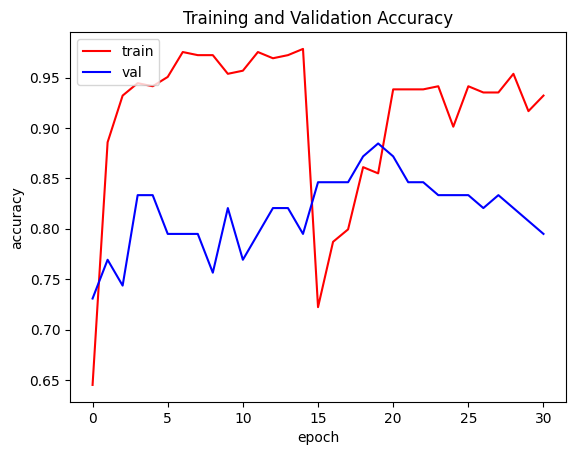

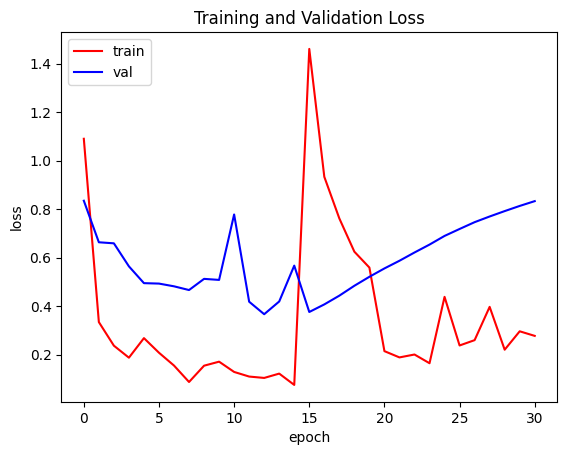

In [20]:
# Menampilkan grafik hasil akurasi dan loss 
acc = full_history_df['accuracy']
val_acc = full_history_df['val_accuracy']
loss = full_history_df['loss']
val_loss = full_history_df['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step


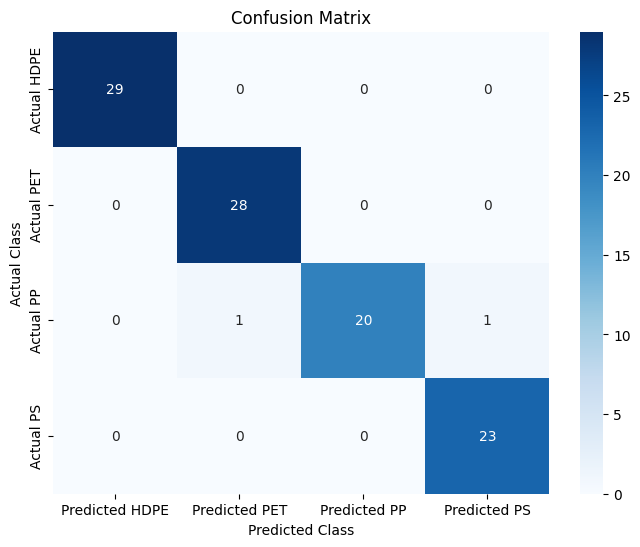


Classification Report:
              precision    recall  f1-score   support

        HDPE     1.0000    1.0000    1.0000        29
         PET     0.9655    1.0000    0.9825        28
          PP     1.0000    0.9091    0.9524        22
          PS     0.9583    1.0000    0.9787        23

    accuracy                         0.9804       102
   macro avg     0.9810    0.9773    0.9784       102
weighted avg     0.9811    0.9804    0.9801       102



In [21]:
# Menampilkan confusion matrix
test_generator.reset()

preds_3 = model_3.predict(test_generator, steps=len(test_generator), verbose=1)
pred_labels = np.argmax(preds_3, axis=1)  

# Ground truth
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f'Actual {c}' for c in class_names],
                        columns=[f'Predicted {c}' for c in class_names])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))